In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_nlp as nlp

from tensorflow import keras
from tensorflow.keras.layers import StringLookup

from utils import handwriting_utils

np.random.seed(42)
tf.random.set_seed(42)

2023-09-04 10:32:05.909146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 10:32:07.206175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


### Reading and Splitting the Dataset

In [2]:
data_dir = './data/handwriting/'
words_list = []

with open(os.path.join(data_dir, 'words.txt')) as f:
    for line in f:
        if line[0] != '#' and line.split(' ')[1] != 'err':
            words_list.append(line)

np.random.shuffle(words_list)
len(words_list)

96454

Dataset will be split by 85:10:5 ratio for training, validation and testing respectively.

In [3]:
split_idx = int(0.85 * len(words_list))
train_samples = words_list[:split_idx]  
test_samples = words_list[split_idx:]

val_split_idx = int(0.67 * len(test_samples))
val_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(train_samples) + len(val_samples) + len(test_samples) == len(words_list)

print(f"Number of training samples: {len(train_samples)}")
print(f"Number of validation samples: {len(val_samples)}")
print(f"Number of test samples: {len(test_samples)}")   

Number of training samples: 81985
Number of validation samples: 9694
Number of test samples: 4775


### Preparing the Data Pipeline

In [4]:
base_image_path = os.path.join(data_dir, 'words')

train_paths, train_labels = handwriting_utils.get_image_paths_and_labels(base_image_path, train_samples)
validation_paths, validation_labels = handwriting_utils.get_image_paths_and_labels(base_image_path, val_samples)
test_paths, test_labels = handwriting_utils.get_image_paths_and_labels(base_image_path, test_samples)

In [5]:
train_paths[0], train_labels[0]

('./data/handwriting/words/b04/b04-121/b04-121-05-07.png',
 'b04-121-05-07 ok 162 1765 1661 153 59 VBG going')

Find the maximum length of the words and size of vocab in the training set. This will be used to create the data pipeline.

In [6]:
train_labels_cleaned = []
characters = set()
max_length = 0

for label in train_labels:
    label = label.split()[-1].strip()
    for char in label:
        characters.add(char)
    max_length = max(max_length, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print(f"Maximum length of label: {max_length}")
print(f"Character Vocab size: {len(characters)}")

train_labels_cleaned[:10]

Maximum length of label: 21
Character Vocab size: 78


['going',
 'proceeded',
 'during',
 'far',
 '"',
 'Gilburg',
 ',',
 'while',
 '?',
 'cricket']

In [7]:
validation_labels_cleaned = handwriting_utils.clean_labels(validation_labels)
test_labels_cleaned = handwriting_utils.clean_labels(test_labels)

#### Building the Character Vocabulary

In [8]:
AUTOTUNE = tf.data.AUTOTUNE 

# Map characters to integers
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Map integers back to original characters
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

2023-09-04 10:32:11.678425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 10:32:11.800019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 10:32:11.800293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 10:32:11.802368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 10:32:11.802598: I tensorflow/compile

#### Resizing images without distortion
 - Resize images such that the aspect ratio is maintained
 - Content of the image is not distorted

In [9]:
BATCH_SIZE = 64
PADDING_TOKEN = 99
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 32

In [10]:
def prepare_dataset(image_paths, labels):
    img_dimensions = (IMAGE_WIDTH, IMAGE_HEIGHT)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        lambda x, y: handwriting_utils.process_image_label(x, y, img_dimensions, char_to_num, max_length, PADDING_TOKEN),
        num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [11]:
train_ds = prepare_dataset(train_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_paths, test_labels_cleaned)

2023-09-04 10:32:14.292297: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


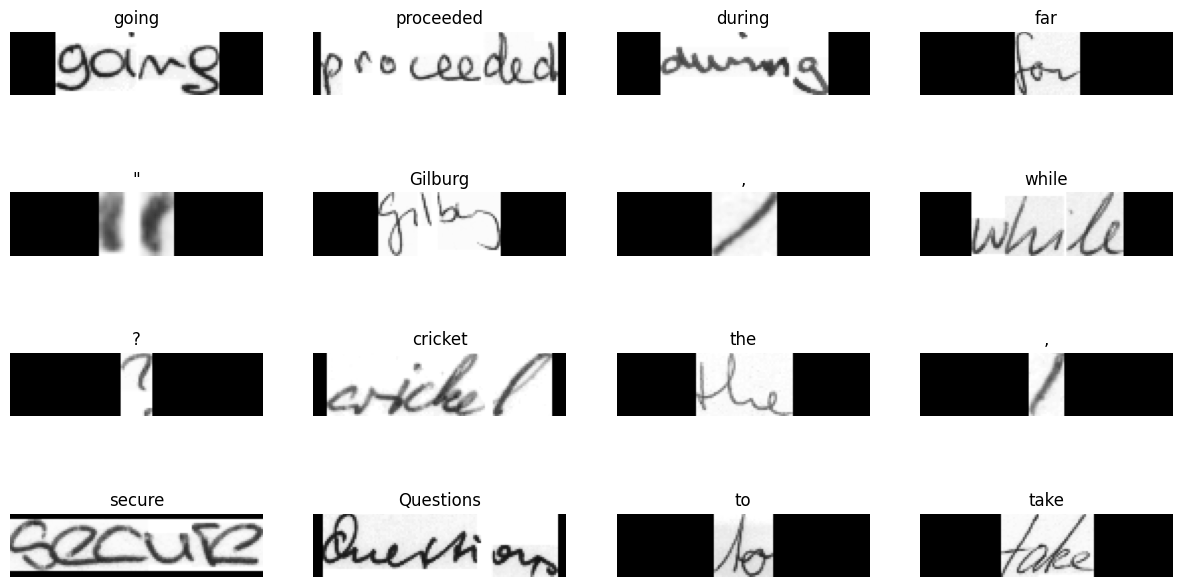

In [12]:
# Visualize the data
for data in train_ds.take(1):
    images, labels = data['image'], data['label']

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img*255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!=99 (PADDING_TOKEN) and convert to string
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode('utf-8')

        ax[i//4, i%4].imshow(img, cmap='gray')
        ax[i//4, i%4].set_title(label)
        ax[i//4, i%4].axis('off')

plt.show()

### Building the Model

In [13]:
# Building the CTCLayer

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64') # type: ignore
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64') # type: ignore

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred
    

In [14]:
# Building the model
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), name='image')
    labels = keras.layers.Input(name='label', shape=(None,))

    # First conv block
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv1')(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name='pool1')(x)

    # Second conv block
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
    x = keras.layers.MaxPooling2D((2, 2), name='pool2')(x)

    # Downsampled feature maps are 4x smaller. The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the output to the RNN part of the model
    new_shape = ((IMAGE_WIDTH // 4), (IMAGE_HEIGHT // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = keras.layers.Dense(64, activation='relu', name='dense1')(x)
    x = keras.layers.Dropout(0.2)(x)

    # LSTM layers
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2')(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name='handwriting_recognizer')

    # Optimizer
    opt = keras.optimizers.Adam()

    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [15]:
def calculate_edit_distance(labels, predictions):
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    input_length = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_length, greedy=True)[0][0][:, :max_length]
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for batch in validation_ds:
            labels = batch['label']
            predictions = self.model.predict_on_batch((batch['image'], labels))
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(f"\nMean edit distance for epoch {epoch+1}: {np.mean(edit_distances):.4f}")

In [16]:
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

### Training

In [17]:
prediction_model = keras.models.Model(
    model.get_layer(name='image').input, model.get_layer(name='dense2').output 
)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [22]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=validation_ds, 
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        edit_distance_callback
    ]
)

Epoch 1/100


1281/1282 [============================>.] - ETA: 0s - loss: 1.4000
Mean edit distance for epoch 1: 17.3939
1282/1282 [==============================] - 133s 103ms/step - loss: 1.4000 - val_loss: 1.6428
Epoch 2/100
1281/1282 [============================>.] - ETA: 0s - loss: 1.3773
Mean edit distance for epoch 2: 17.3924
1282/1282 [==============================] - 137s 107ms/step - loss: 1.3773 - val_loss: 1.6255
Epoch 3/100
1281/1282 [============================>.] - ETA: 0s - loss: 1.3828
Mean edit distance for epoch 3: 17.4049
1282/1282 [==============================] - 137s 107ms/step - loss: 1.3828 - val_loss: 1.6669
Epoch 4/100
1281/1282 [============================>.] - ETA: 0s - loss: 1.3772
Mean edit distance for epoch 4: 17.3818
1282/1282 [==============================] - 137s 107ms/step - loss: 1.3772 - val_loss: 1.6302
Epoch 5/100
1281/1282 [============================>.] - ETA: 0s - loss: 1.3607
Mean edit distance for epoch 5: 17.4001
1282/1282 [=====================

In [19]:
def plot_loss(history):
  '''Plots the training and validation loss and accuracy from a history object'''

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

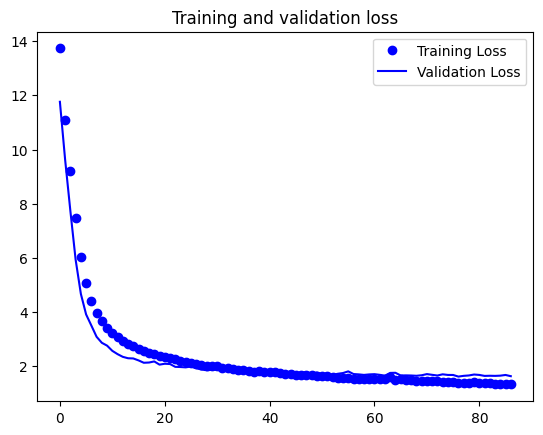

In [20]:
plot_loss(history)

### Evaluation and Inference

In [24]:
model.evaluate(test_ds, verbose=1)

75/75 [==============================] - 9s 102ms/step - loss: 1.6941


1.6941454410552979

In [25]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]

    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text


2/2 [==============================] - 2s 13ms/step


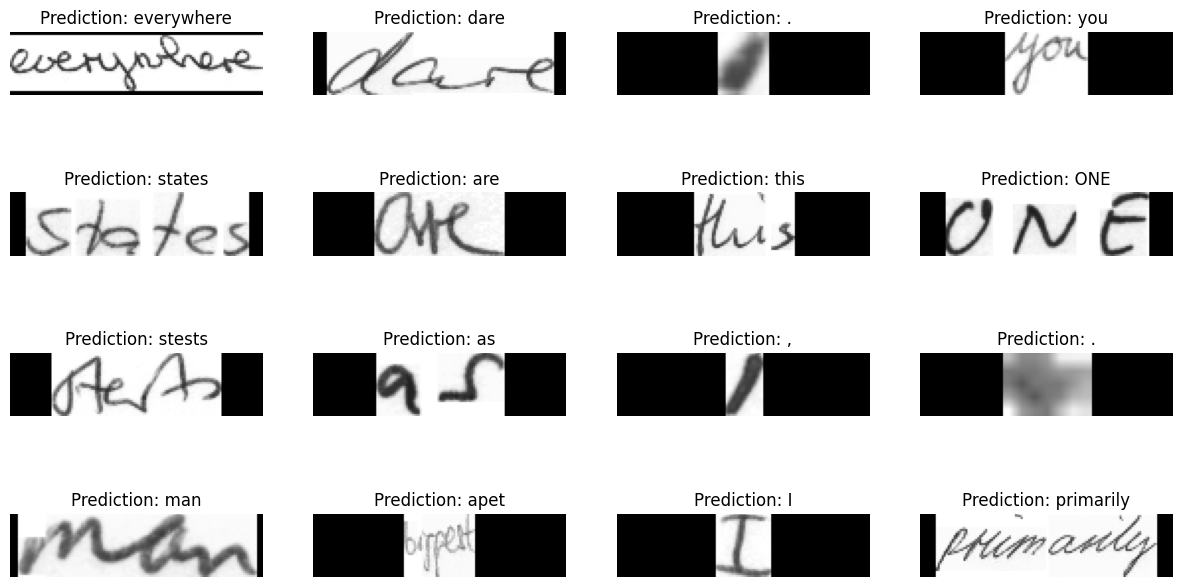

In [26]:
for batch in test_ds.take(1):
    batch_images = batch['image']

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img*255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f'Prediction: {pred_texts[i]}'
        ax[i//4, i%4].imshow(img, cmap='gray')
        ax[i//4, i%4].set_title(title)
        ax[i//4, i%4].axis('off')

plt.show()

In [27]:
prediction_model.save('./models/handwriting-recognition-prediction')
model.save('./models/handwriting-recognition-training')

INFO:tensorflow:Assets written to: ./models/handwriting-recognition-prediction/assets


INFO:tensorflow:Assets written to: ./models/handwriting-recognition-prediction/assets


INFO:tensorflow:Assets written to: ./models/handwriting-recognition-training/assets


INFO:tensorflow:Assets written to: ./models/handwriting-recognition-training/assets
